# EuroSAT Sprint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, models, datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from torch.utils.data import random_split
from collections import Counter
import pandas as pd

## 1. Data loading

In [ ]:
!unzip /content/drive/MyDrive/Train_Test_Splits.zip

In [ ]:
# Define data transformations for training and testing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = '/content/drive/MyDrive/Train_Test_Splits'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataset_sizes

{'train': 21600, 'test': 5400}

In [ ]:
# Split the dataset
train_dataset = image_datasets['train']
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

dataloaders['train'] = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(valid_subset, batch_size=32, shuffle=False, num_workers=4)
dataset_sizes['train'] = len(train_subset)
dataset_sizes['valid'] = len(valid_subset)

## 2. Model training

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(image_datasets['train'].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 324MB/s]


Epoch 0/14
train_loss: 0.1973, train_acc: 0.9380
valid_loss: 0.1471, valid_acc: 0.9542
Epoch 1/14
train_loss: 0.1823, train_acc: 0.9427
valid_loss: 0.1265, valid_acc: 0.9630
Epoch 2/14
train_loss: 0.1719, train_acc: 0.9468
valid_loss: 0.1307, valid_acc: 0.9609
Epoch 3/14
train_loss: 0.1628, train_acc: 0.9460
valid_loss: 0.1330, valid_acc: 0.9597
Epoch 4/14
train_loss: 0.1559, train_acc: 0.9519
valid_loss: 0.1245, valid_acc: 0.9595
Epoch 5/14
train_loss: 0.1436, train_acc: 0.9543
valid_loss: 0.1312, valid_acc: 0.9611
Epoch 6/14
train_loss: 0.1425, train_acc: 0.9553
valid_loss: 0.1105, valid_acc: 0.9637
Epoch 7/14
train_loss: 0.1362, train_acc: 0.9569
valid_loss: 0.1366, valid_acc: 0.9581
Epoch 8/14
train_loss: 0.1183, train_acc: 0.9628
valid_loss: 0.1245, valid_acc: 0.9588
Epoch 9/14
train_loss: 0.1217, train_acc: 0.9622
valid_loss: 0.1217, valid_acc: 0.9630
Epoch 10/14
train_loss: 0.1236, train_acc: 0.9608
valid_loss: 0.1057, valid_acc: 0.9655
Epoch 11/14
train_loss: 0.1098, train_acc:

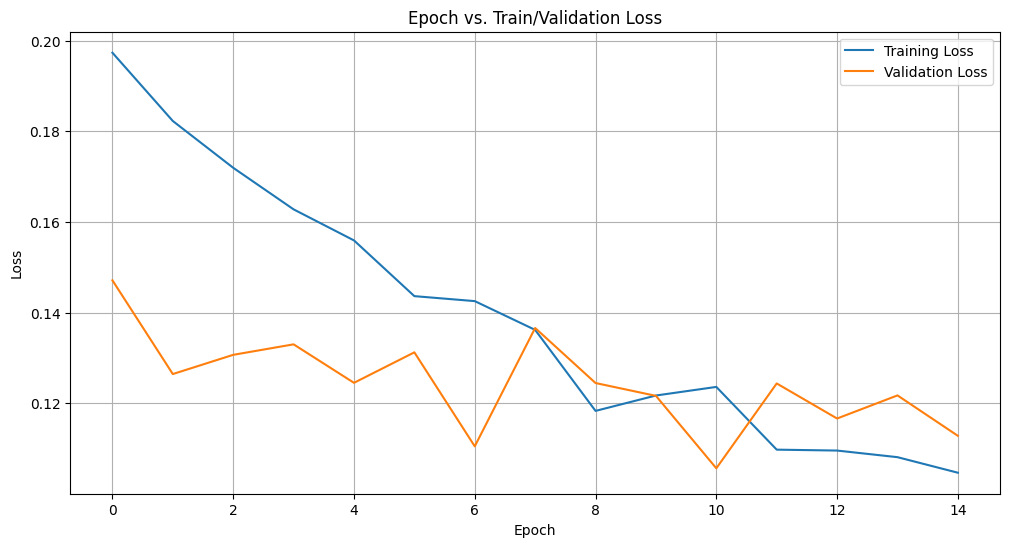

In [ ]:
# Record the loss
train_losses = []
valid_losses = []

# Training and validation loop for each epoch, there will be a training and validation
num_epochs = 15
for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    metrics = {
        'train': {'loss': 0.0, 'correct': 0},
        'valid': {'loss': 0.0, 'correct': 0}
    }

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()  # training mode
        else:
            model.eval()   # evaluate mode

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Update metrics
            metrics[phase]['loss'] += loss.item() * inputs.size(0)
            metrics[phase]['correct'] += torch.sum(preds == labels.data)

        # Calculate epoch metrics
        epoch_loss = metrics[phase]['loss'] / dataset_sizes[phase]
        epoch_acc = metrics[phase]['correct'].double() / dataset_sizes[phase]
        print(f"{phase}_loss: {epoch_loss:.4f}, {phase}_acc: {epoch_acc:.4f}")

    train_losses.append(metrics['train']['loss'] / dataset_sizes['train'])
    valid_losses.append(metrics['valid']['loss'] / dataset_sizes['valid'])


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs. Train/Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 3. Model evaluation

In [ ]:
model.eval()
true_labels = []
predictions = []

# Store the indices of the correct/incorrect predictions and their probabilities
incorrect_indices = []
incorrect_probs = []
correct_indices = []
correct_probs = []
total_probs = []

for idx, (inputs, labels) in enumerate(dataloaders['valid']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    true_labels.extend(labels.cpu().numpy())
    predictions.extend(preds.cpu().numpy())

    # Store the incorrectly and correctly classified images and their probabilities
    for i, (pred, label) in enumerate(zip(preds, labels)):
        total_probs.append(outputs[i].cpu().numpy())
        if pred != label:
            incorrect_indices.append(idx * dataloaders['valid'].batch_size + i)
            incorrect_probs.append(outputs[i].cpu().numpy())
        else:
            correct_indices.append(idx * dataloaders['valid'].batch_size + i)
            correct_probs.append(outputs[i].cpu().numpy())

# Get a test accuracy
test_acc = np.sum(np.array(true_labels) == np.array(predictions)) / len(true_labels)
print('')
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(f'Number of Correct Predictions: {np.sum(np.array(true_labels) == np.array(predictions))} / 5400')
print(f'Number of Incorrect Predictions: {len(true_labels) - np.sum(np.array(true_labels) == np.array(predictions))} / 5400')

# Save strings of class labels
class_labels = image_datasets['valid'].classes

# Map integer values with string values
true_labels_str = [class_labels[i] for i in true_labels]
predictions_str = [class_labels[i] for i in predictions]

### Analyze correct predictions

In [ ]:
# Randomly select 15 correct predictions to visualize
random_correct_indices = random.sample(correct_indices, 15)

for i, idx in enumerate(random_correct_indices):
    input_image, true_label = dataloaders['valid'].dataset[idx]
    prob_vector = total_probs[idx]
    prob_vector_normalized = np.exp(prob_vector) / np.exp(prob_vector).sum()
    plt.figure(figsize=(8, 4))
    
    # Display the image with rescaled pixel values
    plt.subplot(1, 2, 1)
    input_image = input_image.permute(1, 2, 0).numpy()
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    plt.imshow(input_image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Image', fontsize=8)
    plt.title(f'True Label: {true_labels_str[idx]}\nPredicted Label: {predictions_str[idx]}', fontsize=8)
    plt.grid(False)
    
    # Display the class probabilities with annotations
    plt.subplot(1, 2, 2)
    plt.bar(class_labels, prob_vector_normalized)
    plt.xticks(rotation=60, fontsize=7)
    plt.yticks(fontsize=8)
    plt.ylabel('Probability', fontsize=6)
    plt.title('Class Probabilities', fontsize=8)
    
    for j, prob in enumerate(prob_vector_normalized):
        plt.text(j, prob, f'{prob:.2f}', ha='center', va='bottom', fontsize=6, color='black')
    
    plt.tight_layout(pad=0.6)
    plt.show()

### Analyze incorrect predictions

In [ ]:
# Visualize the incorrect predictions and their probabilities
for i, idx in enumerate(incorrect_indices):
    prob_vector = incorrect_probs[i]
    prob_vector_normalized = np.exp(prob_vector) / np.exp(prob_vector).sum()
    plt.figure(figsize=(8, 4))
    
    # Display the image with rescaled pixel values
    plt.subplot(1, 2, 1)
    input_image = input_image.permute(1, 2, 0).numpy()
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    plt.imshow(input_image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Image', fontsize=8)
    plt.title(f'True Label: {true_labels_str[idx]}\nPredicted Label: {predictions_str[idx]}', fontsize=8)
    plt.grid(False)
    
    # Display the class probabilities with annotations
    plt.subplot(1, 2, 2)
    plt.bar(class_labels, prob_vector_normalized)
    plt.xticks(rotation=60, fontsize=7)
    plt.yticks(fontsize=8)
    plt.ylabel('Probability', fontsize=6)
    plt.title('Class Probabilities', fontsize=8)
    
    for j, prob in enumerate(prob_vector_normalized):
        plt.text(j, prob, f'{prob:.2f}', ha='center', va='bottom', fontsize=6, color='black')
    
    plt.tight_layout(pad=0.6)
    plt.show()

In [ ]:
# Count the combinations of true and predicted labels for incorrect predictions
combination_counts = Counter(zip(true_labels_str, predictions_str))

# Create a dataFrame to organize the metrics
metrics_table = pd.DataFrame.from_dict(combination_counts, orient='index', columns=['Count'])
metrics_table.index = pd.MultiIndex.from_tuples(metrics_table.index, names=['True Label', 'Predicted Label'])

# Sort the table by the count
metrics_table = metrics_table.sort_values(by=['Count'], ascending=False)

print(metrics_table)

In [ ]:
#Print index of incorrect analysis, true label, predicted label
#make an array, at index = true_labels[idx] ++ the integer value
integer_array = [0] * 10

c_lables = image_datasets['train'].classes
for idx in range(len(true_labels)):
    if true_labels[idx] != predictions[idx]:
      print(f"At index {idx}: True Label - {c_lables[true_labels[idx]]}, Predicted Label - {c_lables[predictions[idx]]}")
      integer_array[true_labels[idx]]+=1

for idx in range(len(c_lables)):
  print(f"{c_lables[idx]}: {integer_array[idx]}")


### Make a confusion matrix

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels_str, predictions_str)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=0.7)
ax = sns.heatmap(conf_matrix, annot=True, fmt='.3f', cmap='Blues', 
                 xticklabels=class_labels, 
                 yticklabels=class_labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of ResNet-50 on the EuroSAT dataset')

# Add a black border around the confusion matrix
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')

plt.show()